In [250]:
import pickle

# load the scenario properties file
with open('../scenario-properties-collision.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)
    

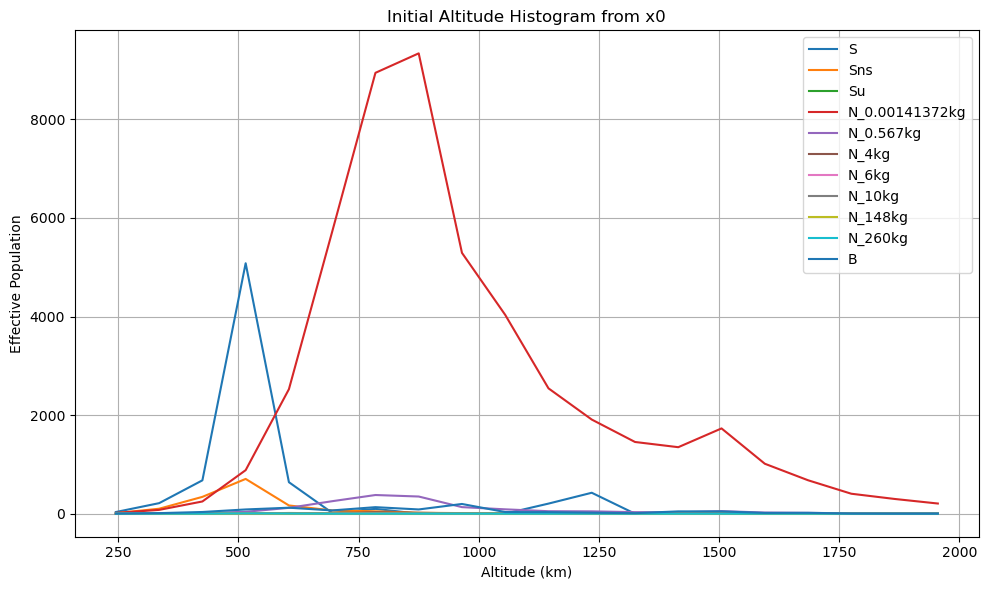

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Plot: One line per species ---
plt.figure(figsize=(10, 6))
for s in range(n_species):
    plt.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

plt.xlabel("Altitude (km)")
plt.ylabel("Effective Population")
plt.title("Initial Altitude Histogram from x0")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # Log scale for better visibility
plt.show()

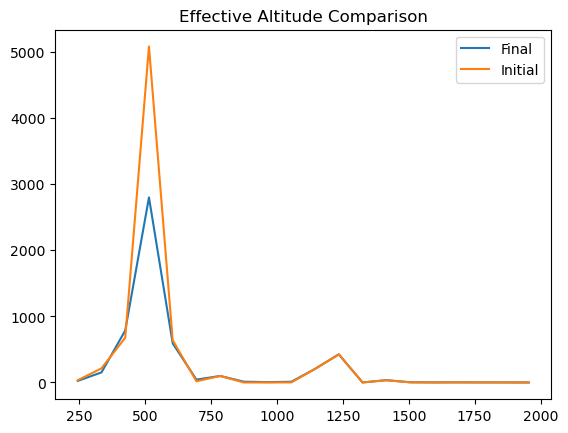

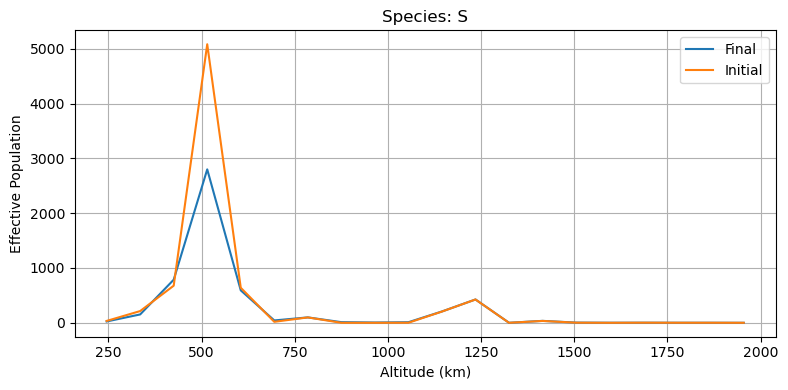

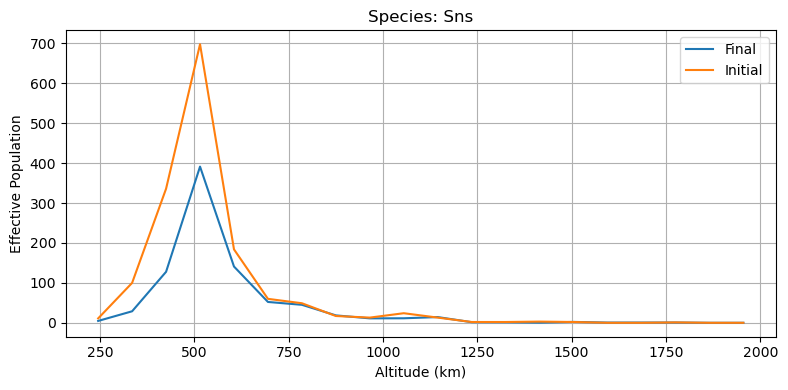

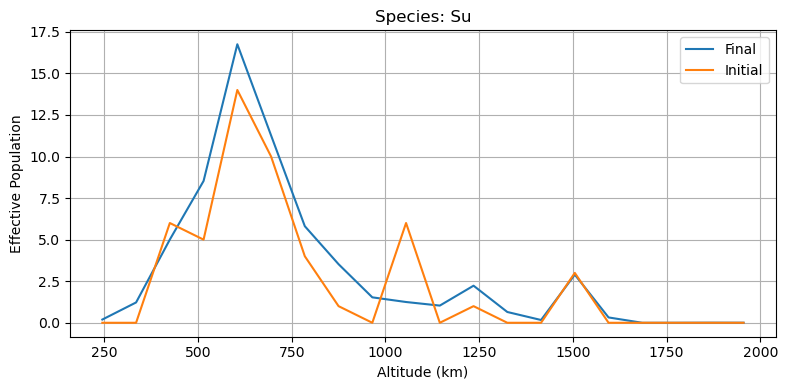

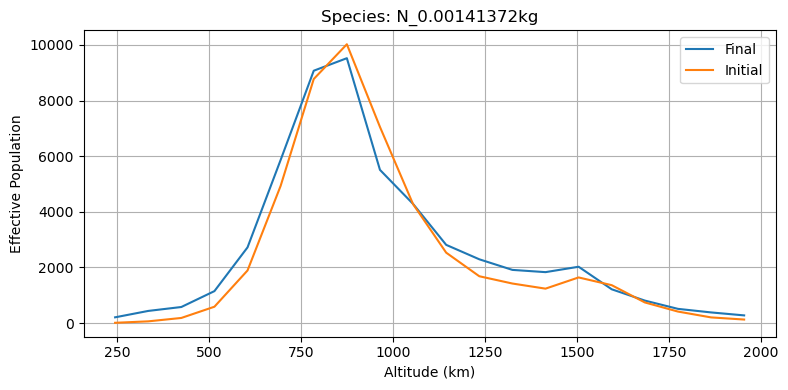

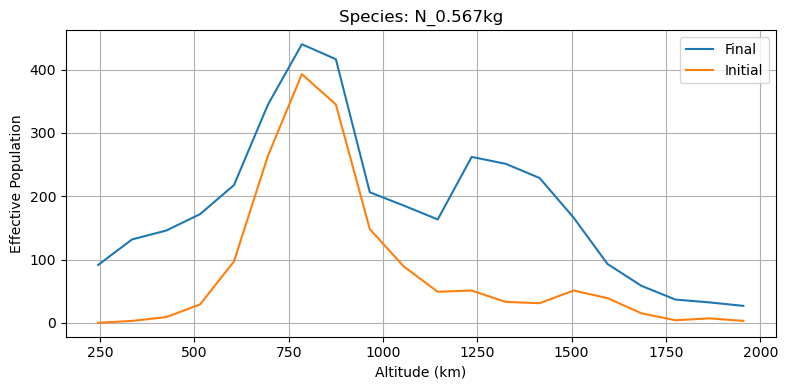

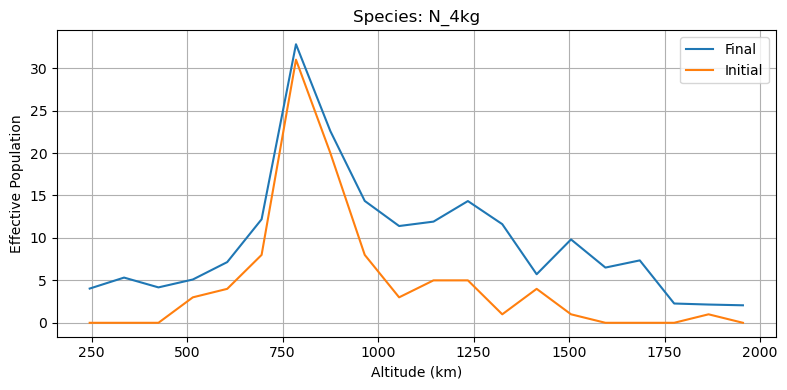

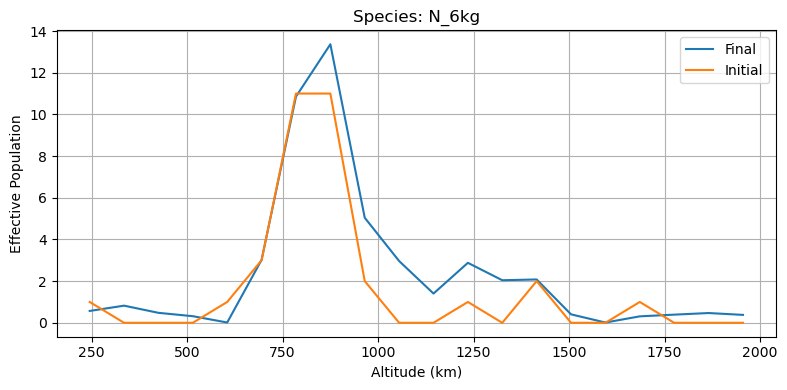

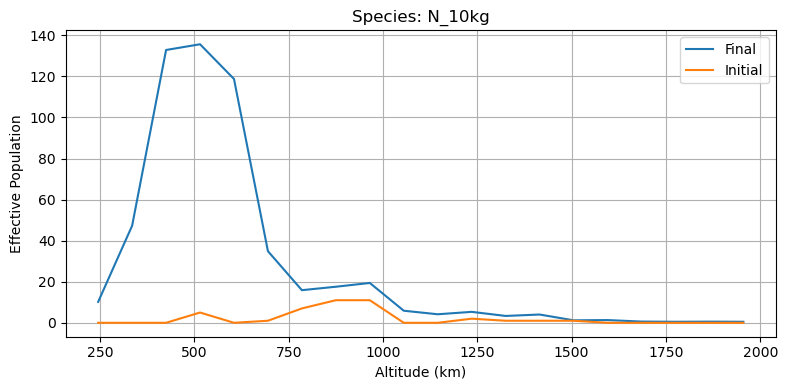

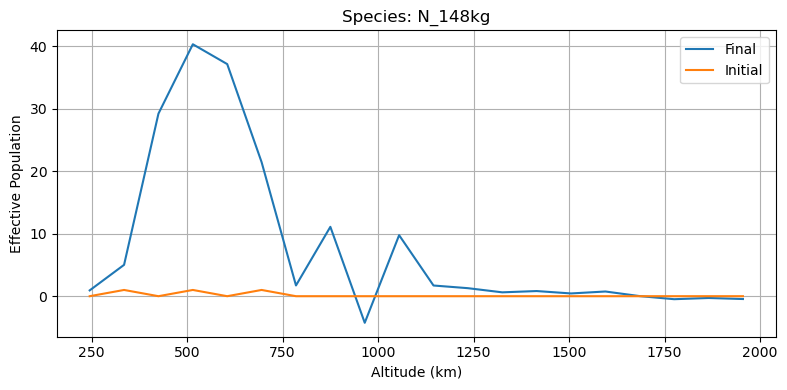

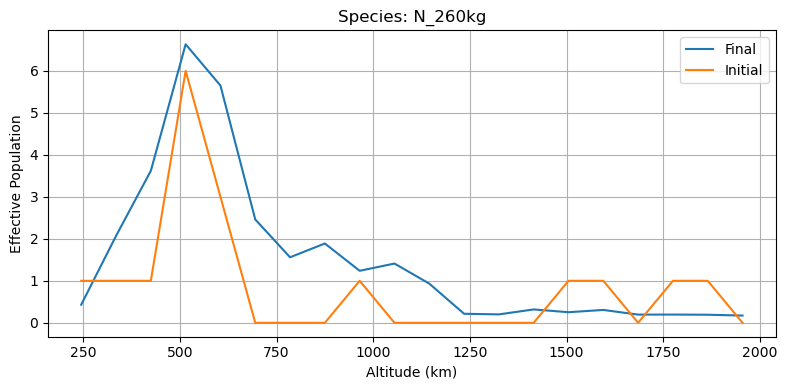

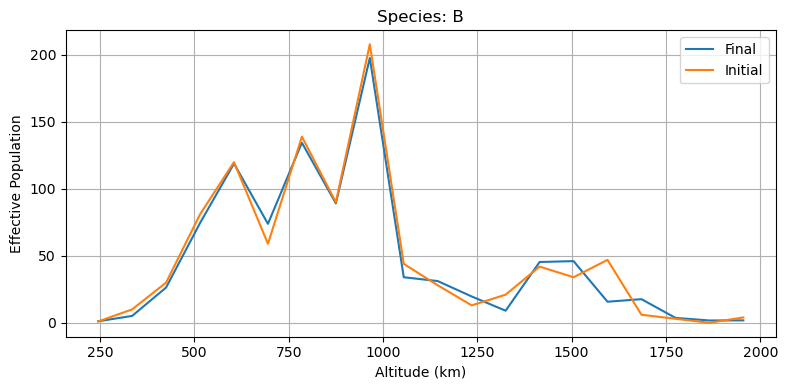

In [252]:
plt.plot(scenario_properties.HMid, scenario_properties.effective_altitude_matrix[:, 0], label='Final')
plt.plot(scenario_properties.HMid, scenario_properties.x0[:, 0, :].sum(axis=-1), label='Initial')
plt.legend(); plt.title("Effective Altitude Comparison"); plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Unpack
altitudes = scenario_properties.HMid
species_names = scenario_properties.species_names
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
final = scenario_properties.effective_altitude_matrix  # shape: (altitude, species)

n_species = len(species_names)

# Plot for each species
for s in range(n_species):
    plt.figure(figsize=(8, 4))
    
    # Final effective altitude distribution
    plt.plot(altitudes, final[:, s], label="Final")
    
    # Initial distribution mapped to altitude by summing x0 over ecc
    initial = x0[:, s, :].sum(axis=-1)  # shape: (sma,)
    plt.plot(altitudes, initial, label="Initial")

    plt.title(f"Species: {species_names[s]}")
    plt.xlabel("Altitude (km)")
    plt.ylabel("Effective Population")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [253]:
scenario_properties.sma_ecc_mat_to_altitude_mat

<bound method ScenarioProperties.sma_ecc_mat_to_altitude_mat of <utils.simulation.scen_properties.ScenarioProperties object at 0x33f3347c0>>

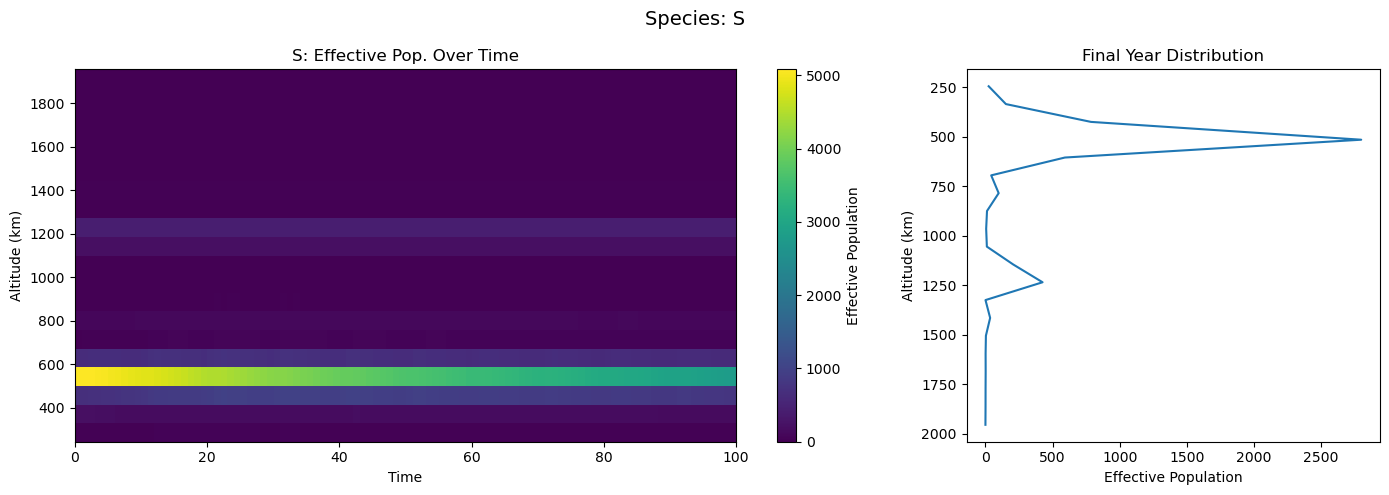

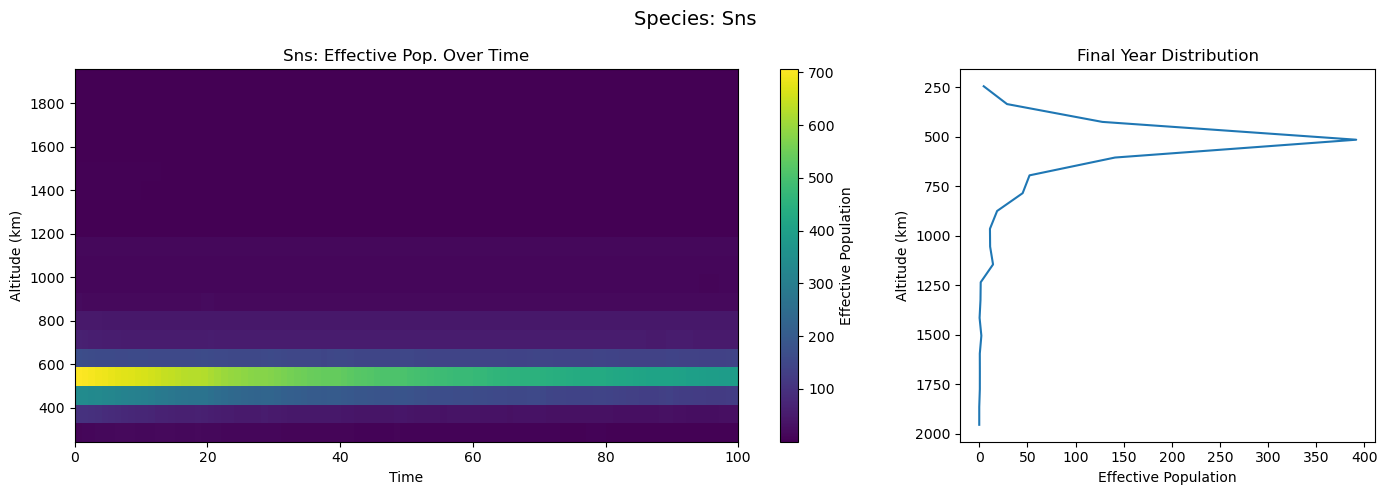

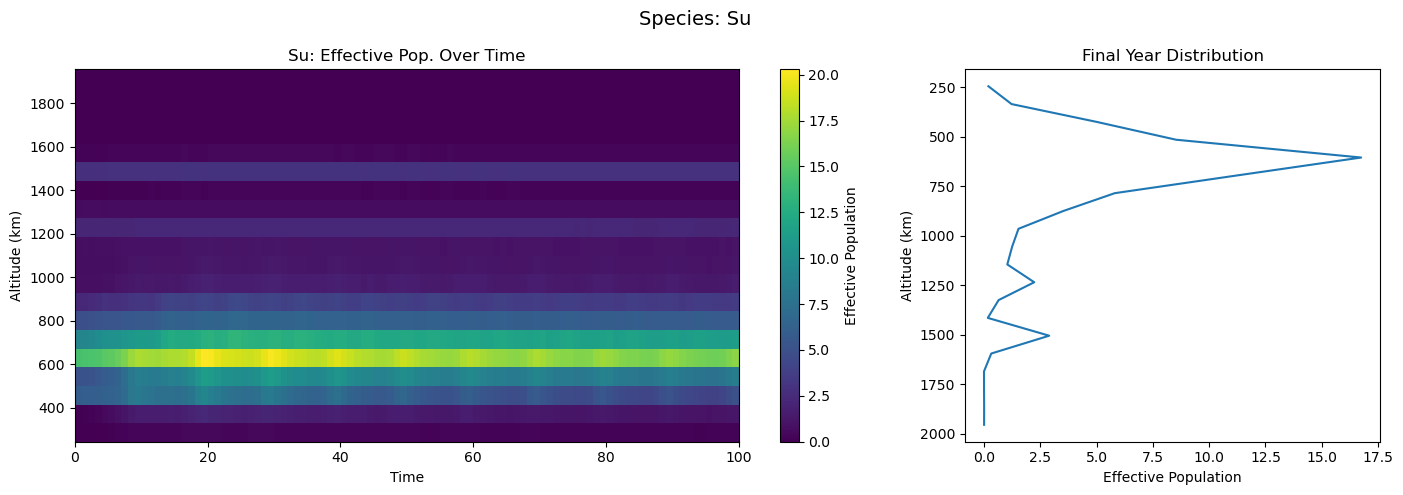

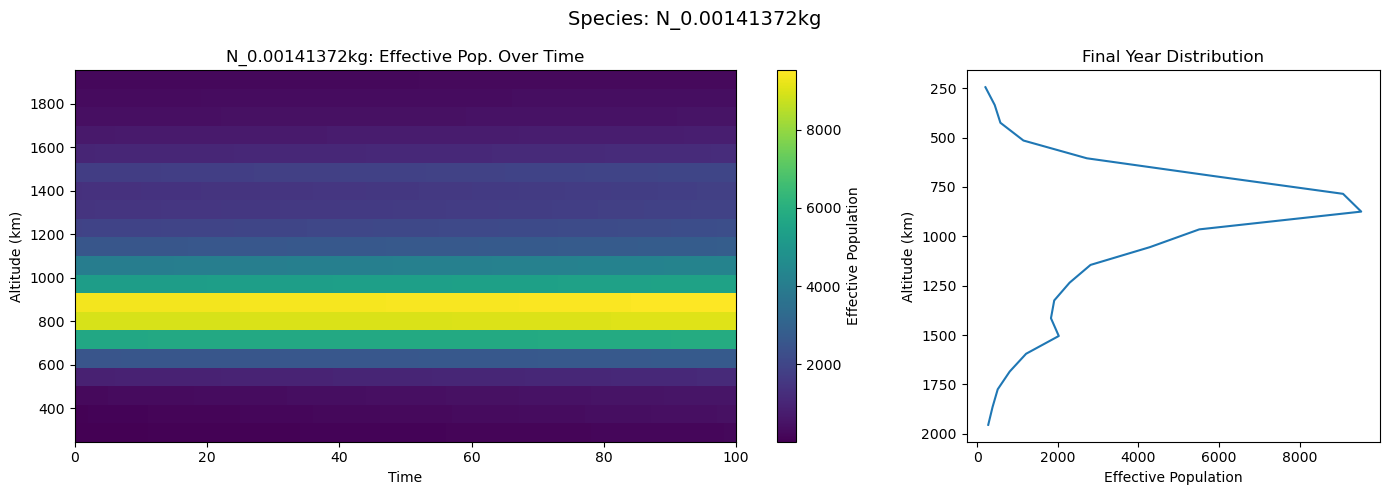

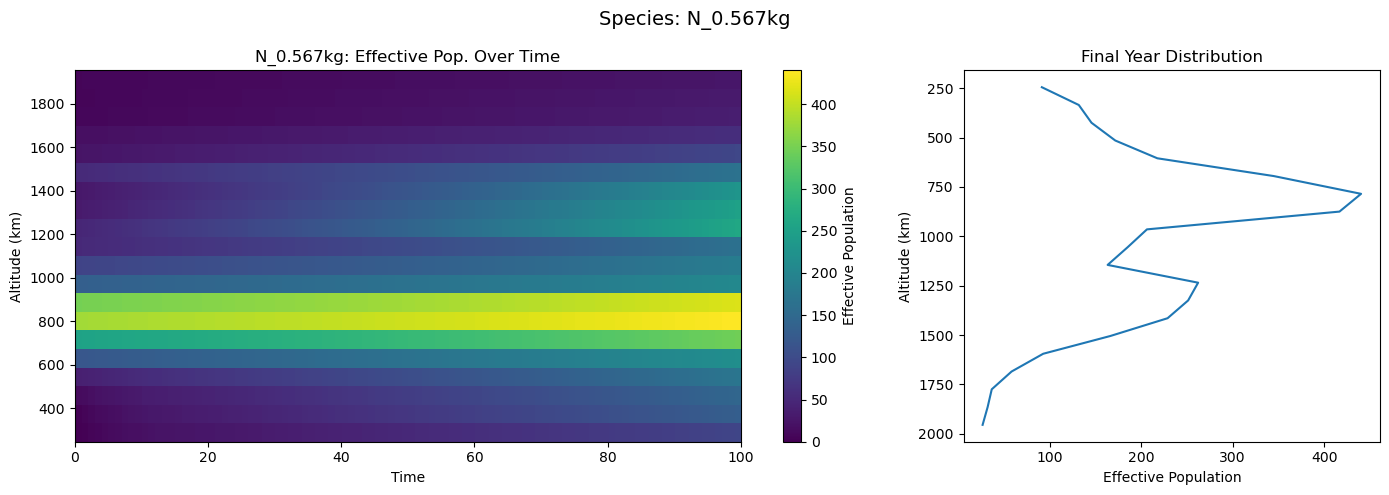

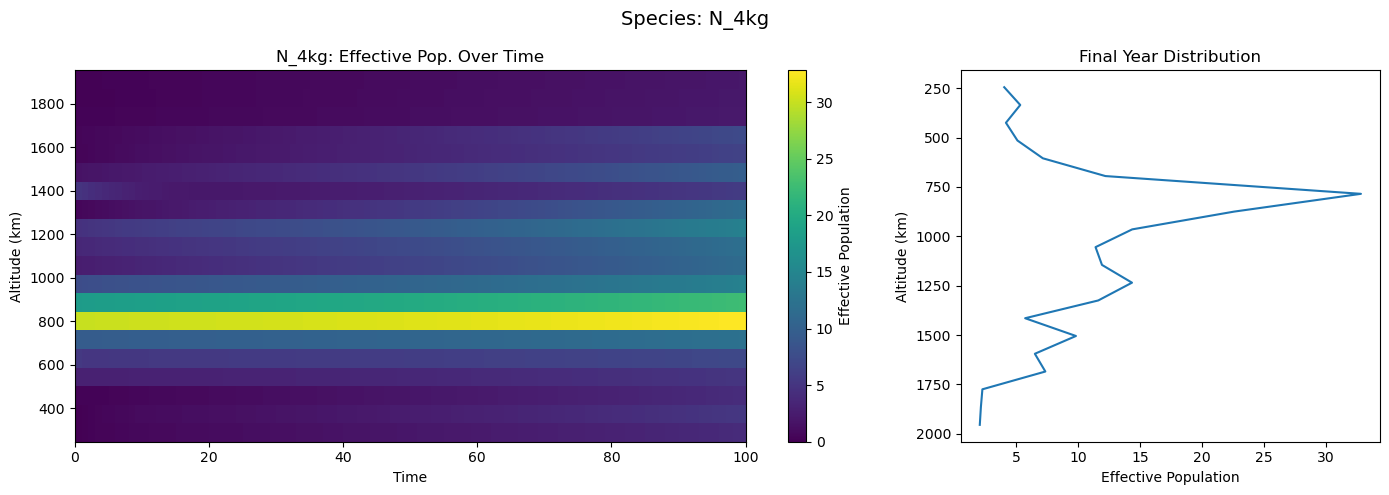

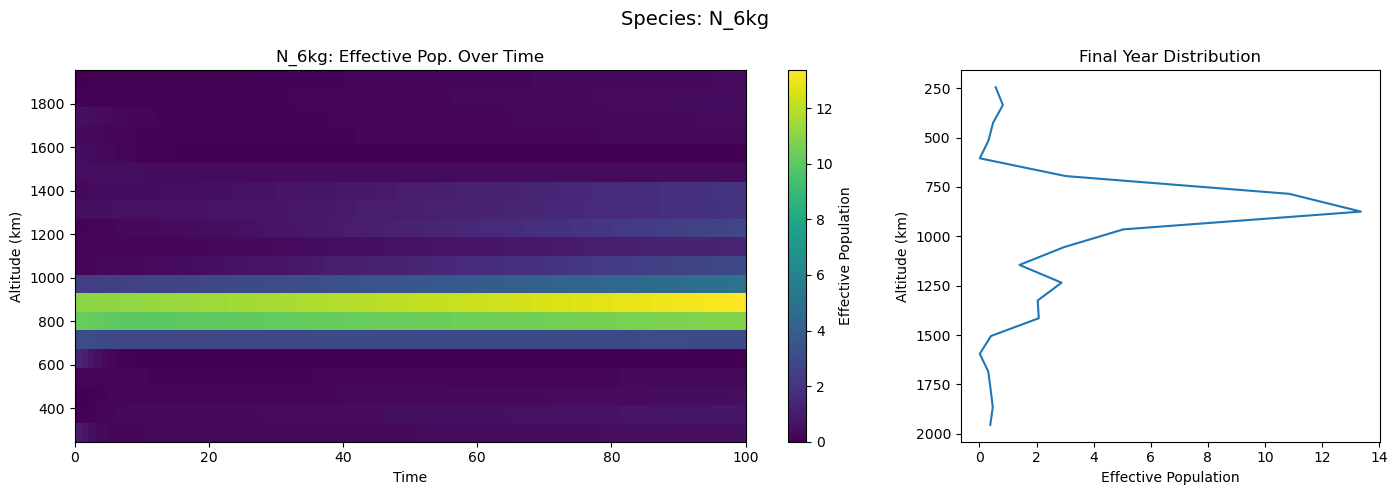

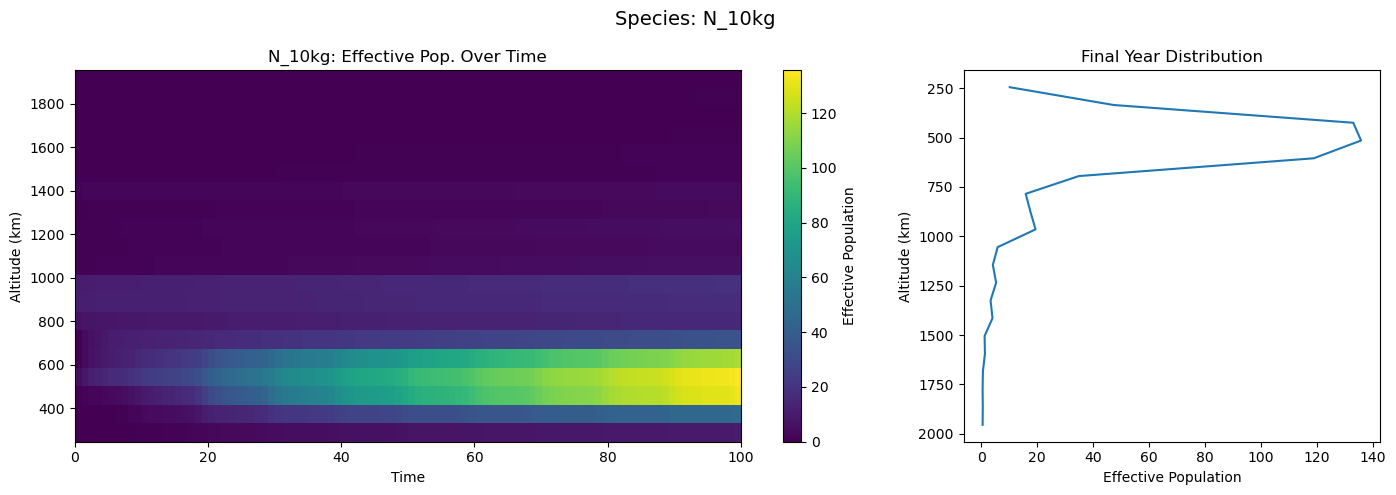

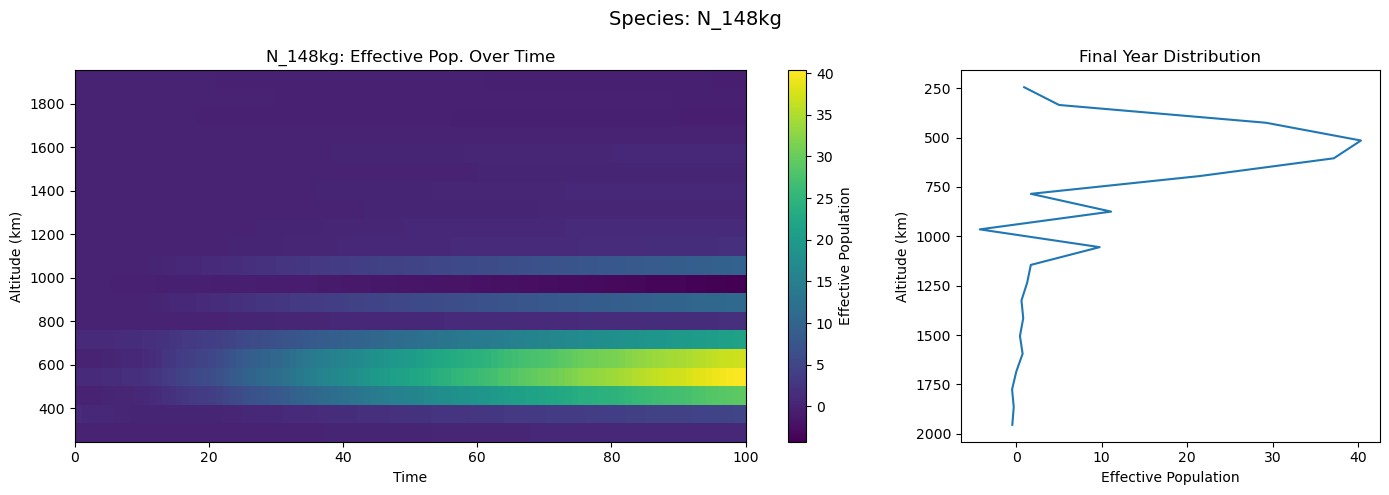

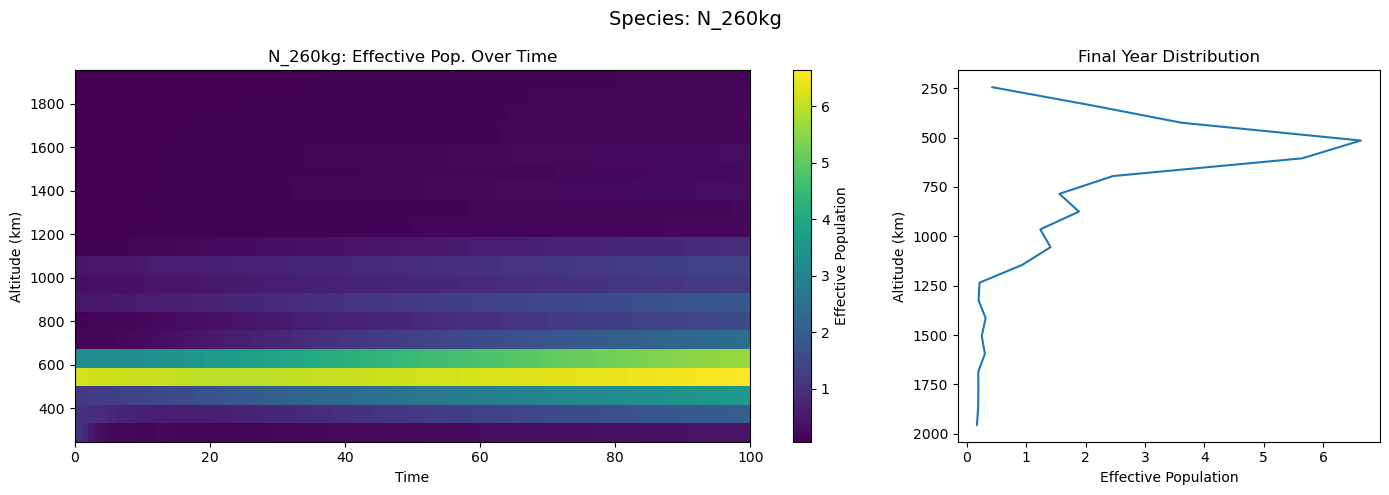

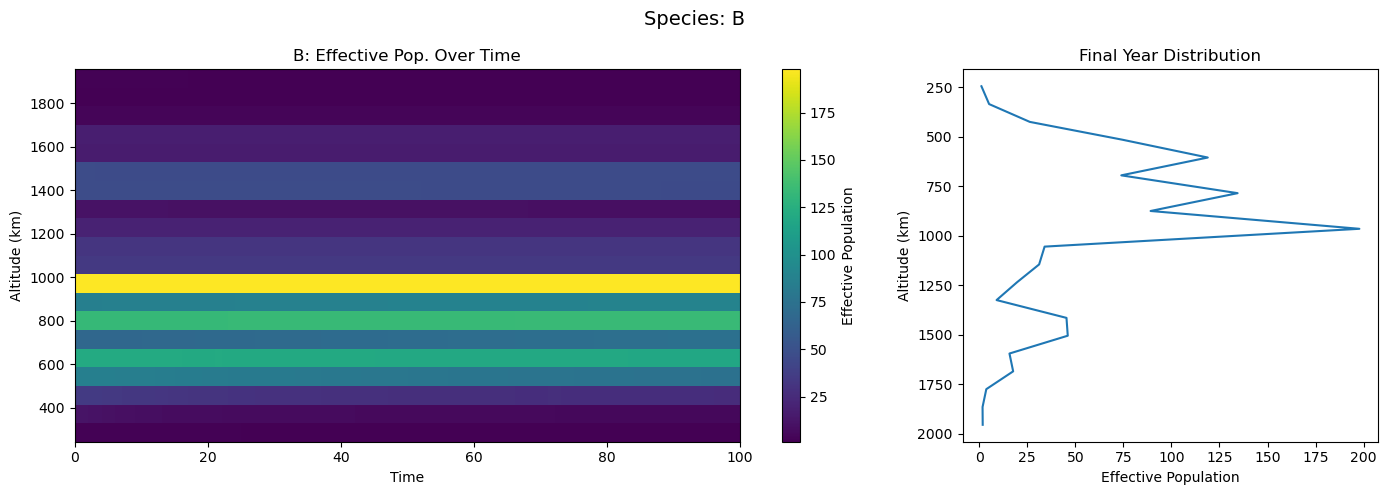

In [254]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_alt_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
n_time = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # Altitude midpoints

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)  # shape: (sma, species, ecc, time)

# === Plotting ===
for s in range(n_species):
    n_eff_time = np.zeros((n_alt_shells, n_time))  # Altitude shells × time

    for t in range(n_time):
        pop_snapshot = x_matrix[:, s, :, t]  # shape: (sma, ecc)
        
        # Reconstruct full shape (sma, species, ecc) to use in converter
        pop_full = np.zeros((n_sma_bins, n_species, n_ecc_bins))
        pop_full[:, s, :] = pop_snapshot

        # Convert to altitude matrix using your method
        alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(pop_full)
        n_eff_time[:, t] = alt_proj[:, s]

    # Final year distribution
    final_year_dist = n_eff_time[:, -1]

    # --- Create subplot: Heatmap + Final Distribution ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap of effective population over time
    im = axes[0].imshow(n_eff_time, aspect='auto', origin='lower',
                        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
                        cmap='viridis')
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")
    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Effective Altitude

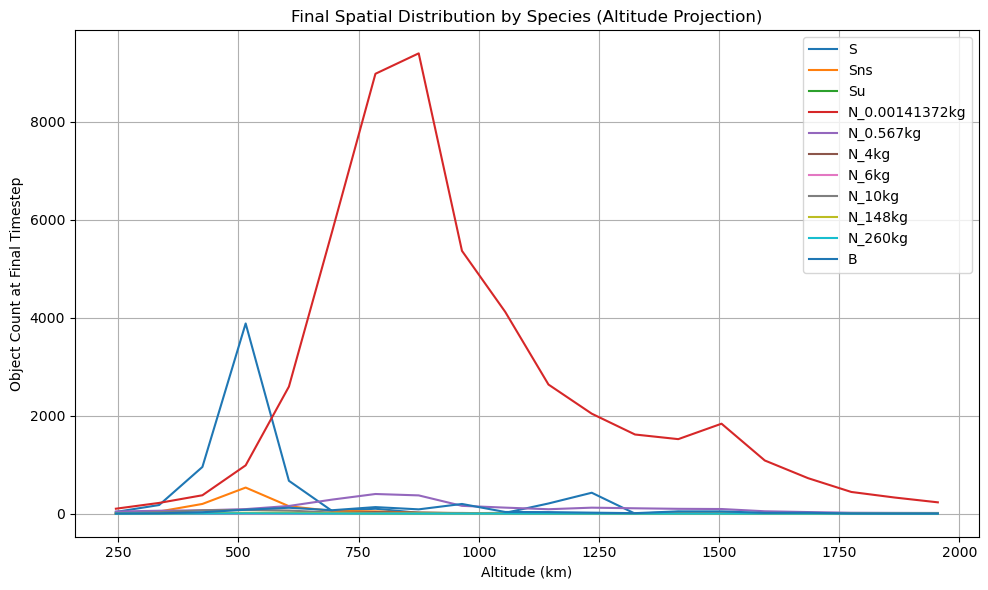

In [255]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack dimensions
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # shape: (n_shells,)
final_step_index = 40 # last times÷tep

# Extract final timestep and reshape
y = scenario_properties.output.y
y_final = y[:, final_step_index]  # shape: (n_sma_bins * n_species * n_ecc_bins,)

# Reshape to (sma, species, ecc)
x_matrix = y_final.reshape((n_sma_bins, n_species, n_ecc_bins))

# Project to altitude using provided method
x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (n_shells, n_species)

# === Plot: Total Altitude Distribution per Species ===
plt.figure(figsize=(10, 6))

for i in range(n_species):
    plt.plot(altitudes, x_alt[:, i], label=species_names[i])

plt.xlabel("Altitude (km)")
plt.ylabel("Object Count at Final Timestep")
plt.title("Final Spatial Distribution by Species (Altitude Projection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

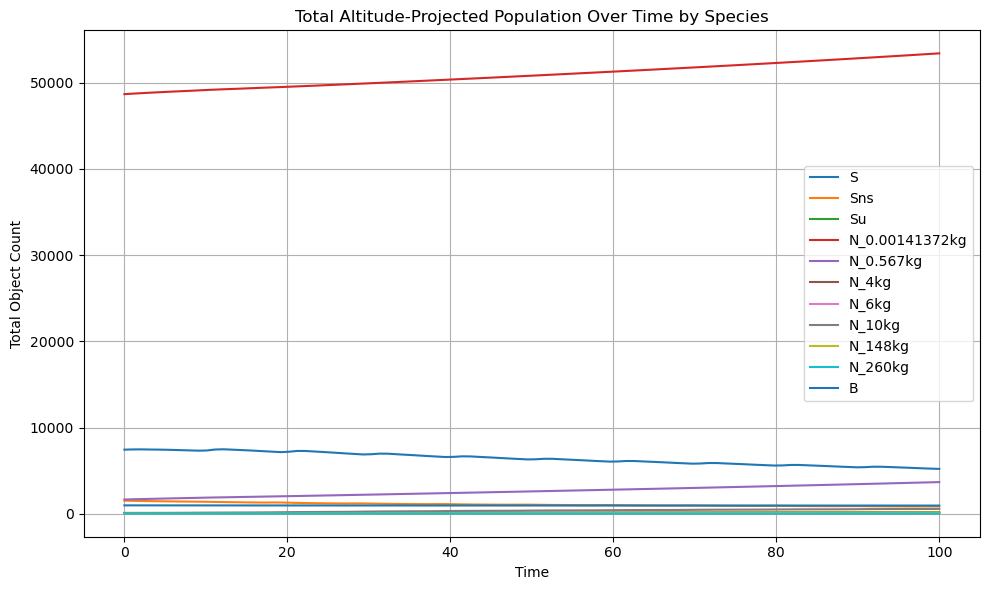

In [256]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # (n_shells,)
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t  # shape: (n_timesteps,)

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))  # shape: (species, time)

# --- Loop over each time step ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]  # shape: (n_sma_bins * n_species * n_ecc_bins,)
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))  # reshape to (sma, species, ecc)
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (alt_shells, species)

    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)  # total per species

# --- Plot ---
plt.figure(figsize=(10, 6))
for i in range(n_species):
    plt.plot(times, species_totals_over_time[i], label=species_names[i])

plt.xlabel("Time")
plt.ylabel("Total Object Count")
plt.title("Total Altitude-Projected Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

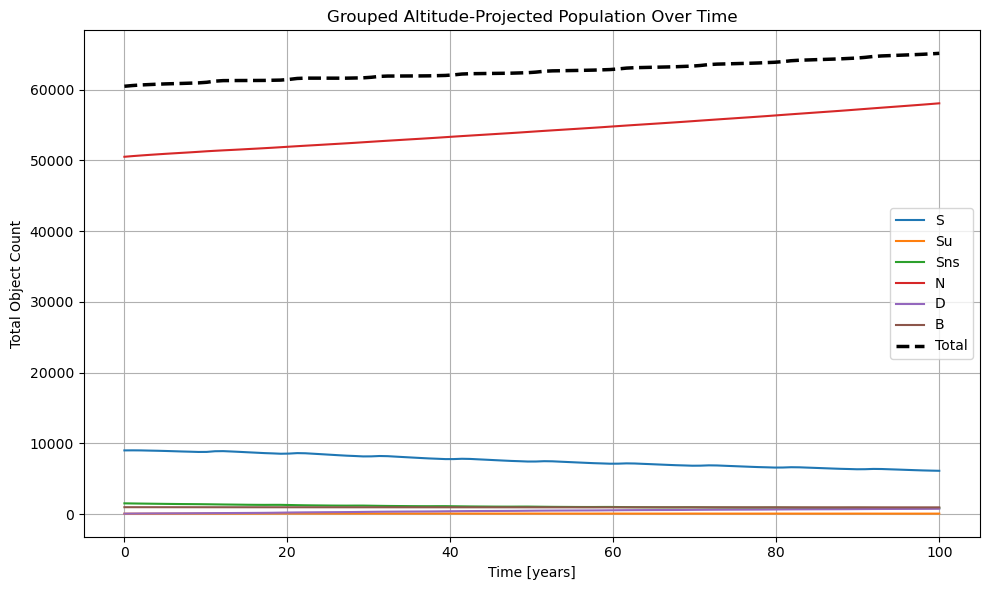

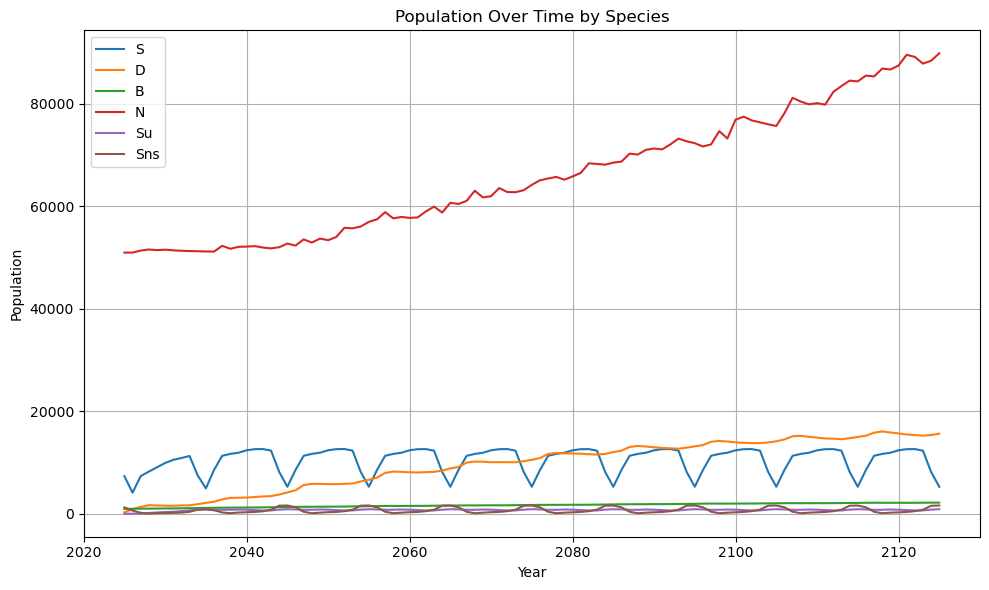

In [257]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))

# --- Project and sum over altitudes ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)
    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)

# --- Define groupings ---
large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg']
group_indices = {
    'S': [i for i, sp in enumerate(species_names) if sp.startswith('S')],
    'Su': [i for i, sp in enumerate(species_names) if sp.startswith('Su')],
    'Sns': [i for i, sp in enumerate(species_names) if sp.startswith('Sns')],
    'N': [i for i, sp in enumerate(species_names) if sp.startswith('N')],
    'D': [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B': [i for i, sp in enumerate(species_names) if sp == 'B']
}

# --- Compute grouped totals ---
group_totals = {group: np.sum(species_totals_over_time[indices], axis=0)
                for group, indices in group_indices.items()}

# --- Plot ---
plt.figure(figsize=(10, 6))
for group, values in group_totals.items():
    plt.plot(times, values, label=group)
plt.plot(times, np.sum(species_totals_over_time, axis=0), label="Total", linewidth=2.5, linestyle='--', color='black')

plt.xlabel("Time [years]")
plt.ylabel("Total Object Count")
plt.title("Grouped Altitude-Projected Population Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# load the MOCAT-MC data
import pandas as pd

mc_launch = '/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv'
mc_pop_time_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time.csv'
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'

mc_pop_time = pd.read_csv(mc_pop_time_path)

plt.figure(figsize=(10, 6))
for species in mc_pop_time["Species"].unique():
    species_df = mc_pop_time[mc_pop_time["Species"] == species]
    plt.plot(species_df["Year"], species_df["Population"], label=species)

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

# compare to mc

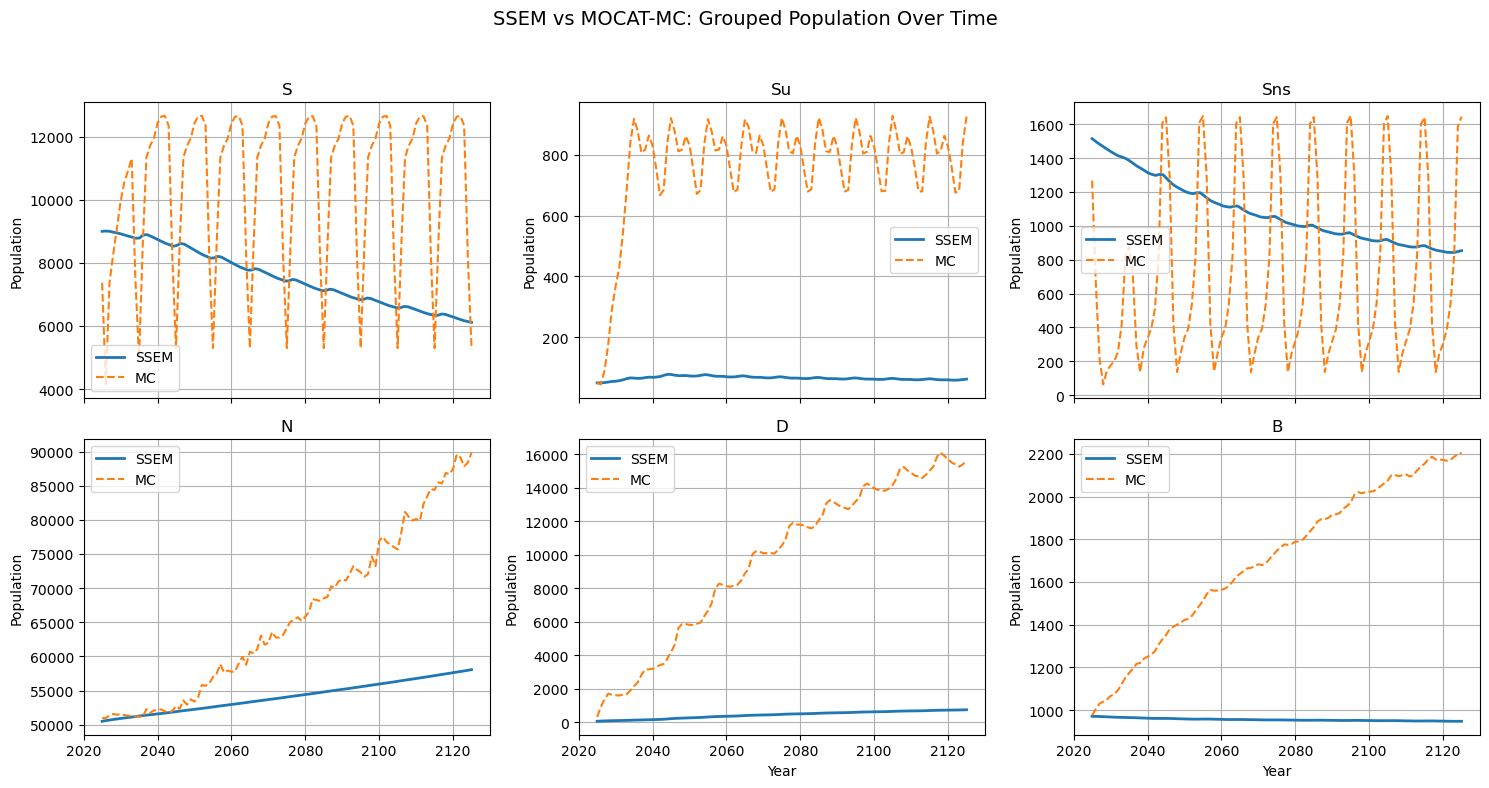

In [258]:
import matplotlib.pyplot as plt

# --- Species groups to compare ---
species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
n_rows, n_cols = 2, 3

start_year = 2025  # Or derive from scenario_properties.start_date
ssem_years = times + start_year

# --- Create subplot grid ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # Plot SSEM
    if group in group_totals:
        ax.plot(ssem_years, group_totals[group], label='SSEM', linewidth=2)

    # Plot MOCAT-MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"], '--', label='MC', linewidth=1.5)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Add shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

plt.suptitle("SSEM vs MOCAT-MC: Grouped Population Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.ticklabel_format(useOffset=False, axis='y')
plt.show()

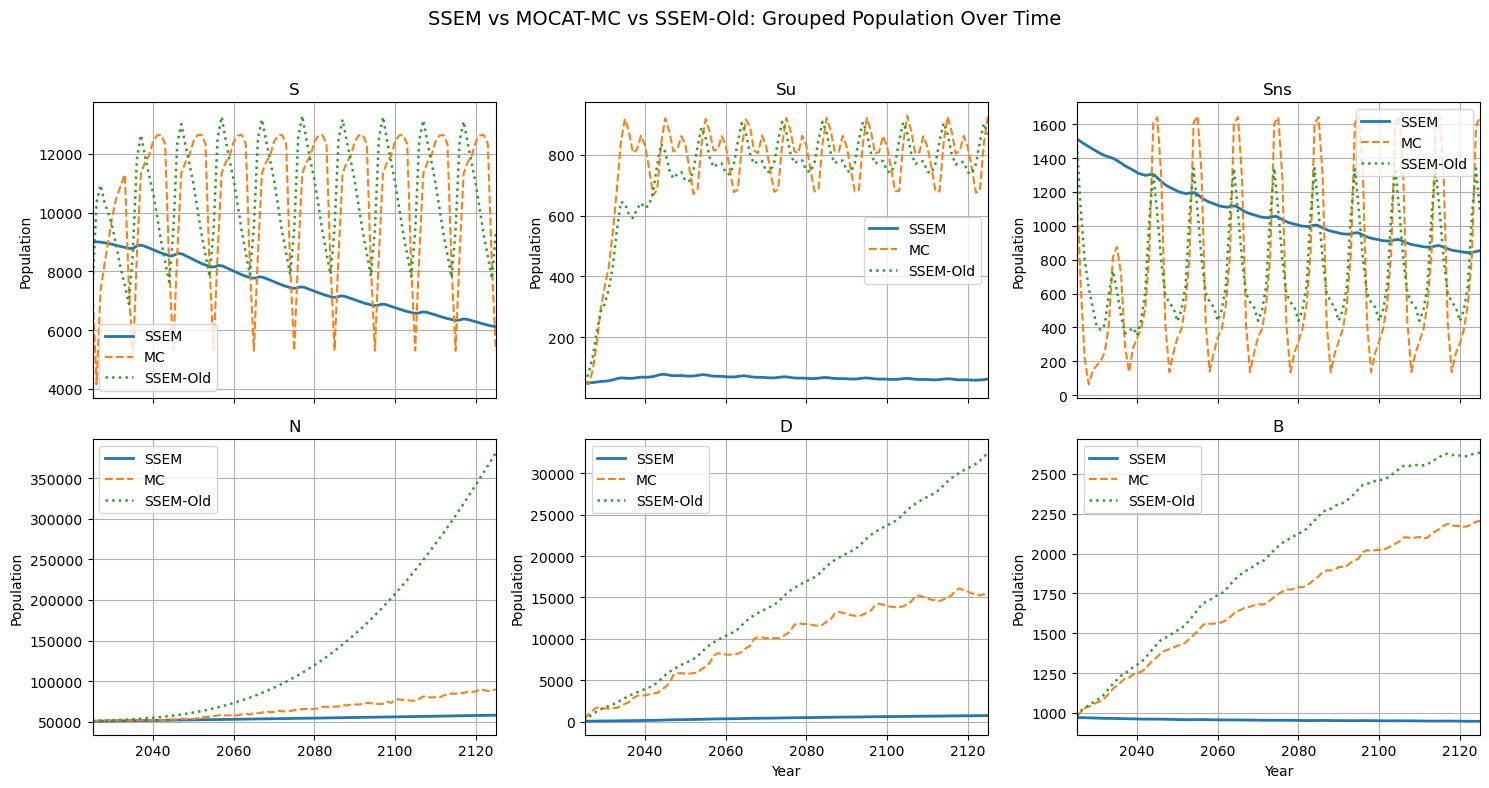

In [259]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load third dataset: SSEM-Old ---
ssem_old_path = "/Users/indigobrownhall/Code/pyssem/figures/SEP-Final-Runs/SEP2/pop_time.csv"
df_ssem_old = pd.read_csv(ssem_old_path)

# remove data where year is older than 2125
df_ssem_old = df_ssem_old[df_ssem_old["Year"] <= 2125]

# --- Species groups to compare ---
species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
n_rows, n_cols = 2, 3

# --- Time adjustment for SSEM ---
start_year = 2025
ssem_years = times + start_year

# --- Create subplot grid ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # Plot SSEM (new)
    if group in group_totals:
        ax.plot(ssem_years, group_totals[group], label='SSEM', linewidth=2)

    # Plot MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"], '--', label='MC', linewidth=1.5)

    # Plot SSEM-Old
    if group in df_ssem_old["Species"].unique():
        old_df = df_ssem_old[df_ssem_old["Species"] == group]
        ax.plot(old_df["Year"], old_df["Population"], ':', label='SSEM-Old', linewidth=1.8)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Add shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

plt.suptitle("SSEM vs MOCAT-MC vs SSEM-Old: Grouped Population Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(2025, 2125)  # Adjust x-axis limits for better visibility
plt.show()

In [260]:
scenario_properties.collision_pairs[0].species2